<h1 align=center style = "color:blue;"><font size = 7 face = "ravie">Homenaje al Capitán Veneno</font></h1>
<hr style = "border-bottom: 4px solid yellow; border-top: 4px solid yellow;">
<img src="archivos/JCA_WC_Final_mediana.png" style = "padding-top:10px;" width="800" height="600" align="center">
<hr style = "border: none; border-bottom: 4px solid yellow; border-top: 4px solid yellow;">

## Guillermo Huerta Montado
### Diciembre 2019

# Introducción<a id="0"></a>

El objetivo de esta publicación es rendir un homenaje póstumo a **Juan Carlos Aragón**, "El Capitán Veneno": poeta, filósofo y reconocido autor de chirigotas y comparsas del Carnaval de Cádiz. 
Para ello, programamos un *web crawler* que obtiene las letras de sus agrupaciones carnavalescas más famosas y, desde éstas, creamos una NUBE DE PALABRAS que nos muestra qué palabras aparecen con mayor frecuencia en sus repertorios.

# Tabla de Contenidos

<div class="alert alert-block alert-info" style="margin-top: 20px; clear:both;">
1. <a href="#0">Introducción</a><br>
2. <a href="#1">Explorando la fuente de datos</a><br>
3. <a href="#2">Conociendo los paquetes que usaremos</a><br>
4. <a href="#3">Obteniendo los datos</a><br>
5. <a href="#4">Creando la visualización</a><br>
6. <a href="#5">Conclusiones</a><br> 
</div>


# Explorando la fuente de los datos<a id="1"></a>

Para poder realizar la nube de palabras objetivo de esta publicación, necesitamos conocer las letras de las obras del artista. A tal fin, hacemos una búsqueda en La Web que nos lleva a encontrar el blog [Letras desde el Paraiso](https://letrasdesdeelparaiso.blogspot.com/) (¡muchas gracias a su creador, Jose Carlos Ortega Diez, por este fantástico repositorio!), donde existe un amplio elenco de letras de agrupaciones del Carnaval de Cádiz, agregadas por autor, agrupación, fecha, etc. Exploramos la web para conocer su estrutura y llegamos a la conclusión de que podemos obtener los datos haciendo una consulta por autor. Sin embargo, las letras de las distintas piezas (presentaciones, pasodobles, cuplés y estribillos) están segregadas en distintas entradas temporales, en orden cronológico descendente. Así pues, necesitaremos realizar varias consultas encadenadas que transcurran por todo el conjunto de datos.

Con objeto de poder recoger estos datos programáticamente, creamos un *web crawler* que recorrerá todos estos enlaces, extraerá las letras y las añadirá a una variable. 

Podremos emplear este *web crawler* en el futuro para obtener datos de otros autores, años o agrupaciones, puesto que los datos están ordenados siguiendo la misma estructura.

# Conociendo los paquetes que usaremos<a id="2"></a>

Aquí hacemos una breve descripcion de los paquetes de Python que empleamos en esta publicación:

* **requests** - Obtención del código *html* de las páginas web. 
* **beautifulsoup4** - "Parseado" del código *html* y extracción de los elementos que necesitamos.
* **wordcloud** - Creación de la nube de palabras.
* **stop-words** - Colección predefinida de palabras reservadas en español.
* **matplotlib** - Visualización de la nube de palabras.
* **numpy** - Creación de *arrays*.
* **PIL** - Conversión de una imágen en un *array* (necesario para la máscara de la visualización).

Si no los tenemos instalados en nuestro entorno Python, podemos obtenerlos mediante el comando:

In [1]:
# pip install -U requests beautifulsoup4 wordcloud stop-words matplotlib numpy PIL


Una vez tenemos los paquetes instalados, pasamos a cargarlos en nuestra sesión de trabajo:

In [2]:
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from stop_words import get_stop_words
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

#Para mostrar la visualización en el *notebook* directamente
%matplotlib inline 

# Obteniendo los datos<a id="3"></a>

En la siguiente sección de código se crea el *web crawler*.

Destacar aquí que comenzamos proporcionándole la dirección web desde la que empezamos la recolección de datos (la entrada más reciente en el blog para las publicaciones relativas a Juan Carlos Aragón) y creando una variable (cadena de texto) vacía donde finalmente quedará almacenado el "corpus" de texto desde el que crearemos la nube de datos:

In [3]:
url = 'https://letrasdesdeelparaiso.blogspot.com/search/label/A%3A%20Juan%20Carlos%20Aragon' 
text_to_analyze = ''

# Este bucle añade a la variable "text_to_analyze" el texto para cada una de las entradas
# y pasa a la siguiente entrada del blog. Si no hay más entradas, se sale del bucle
while True:
    r = requests.get(url)
    html_contents = r.text
    html_soup = BeautifulSoup(html_contents, 'html.parser')
    for found in html_soup.find_all('div', {'class':'MsoNoSpacing'}): #Elemento con las letras
        text_to_analyze += found.text #Añade el texto a la variable
    try:
        url = html_soup.find('a', {'class':'blog-pager-older-link'}).get('href') #Siguiente entrada
    except:
        break

In [4]:
len(text_to_analyze.replace("\n", " ").split())

108051

Más de 100.000 palabras, ¡no está nada mal!

# Creando la visualización<a id="4"></a>

Finalmente, mediante el código de esta sección, creamos la NUBE DE PALABRAS que nos mostrará cuáles son las palabras que más empleó El Capitan Veneno para sus repertorios a lo largo de su extensa carrera.

A continuación, reseñamos varios puntos sobre este apartado:
* Las palabras reservadas son un conjunto de palabras comunes del idioma que pueden soslayarse a la hora de obtener el contenido semantico de una oración.
* Añadimos algunas palabras que no están recogidas en el conjunto predeterminado de palabras reservadas, que el autor empleaba con cierta frecuencia y que entendemos que no aportan valor (i.e., "si", "tan", "va", etc.).
* Filtramos la forma final de la nube de palabras mediante una imagen que hemos diseñado *ad hoc* para esta publicación con las iniciales del autor (JCA). 

In [5]:
# Creamos la variable que contiene el conjunto de palabras reservadas en español
stop_words = set(get_stop_words('spanish'))

# Añadimos algunas palabras
stop_words |= {"si", "tan", "va", "vez", "pa", "do", "va"}

len(stop_words)

314

Más de 300 palabras reservadas.

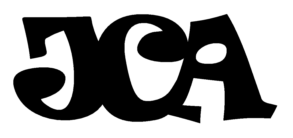

In [6]:
# Creamos una máscara ("¡queesto es cahnavá!") con las iniciales JCA y con la que daremos forma a la nube de palabras
jca_mask = np.array(Image.open('archivos/PlantillaJCA.png'))

# Visualizamos la máscara (a un tamaño pequeño)
fig = plt.figure()
fig.set_figwidth(5)
fig.set_figheight(8.5) 

plt.imshow(jca_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis('off')
plt.show()

Creamos y dibujamos la NUBE DE PALABRAS:

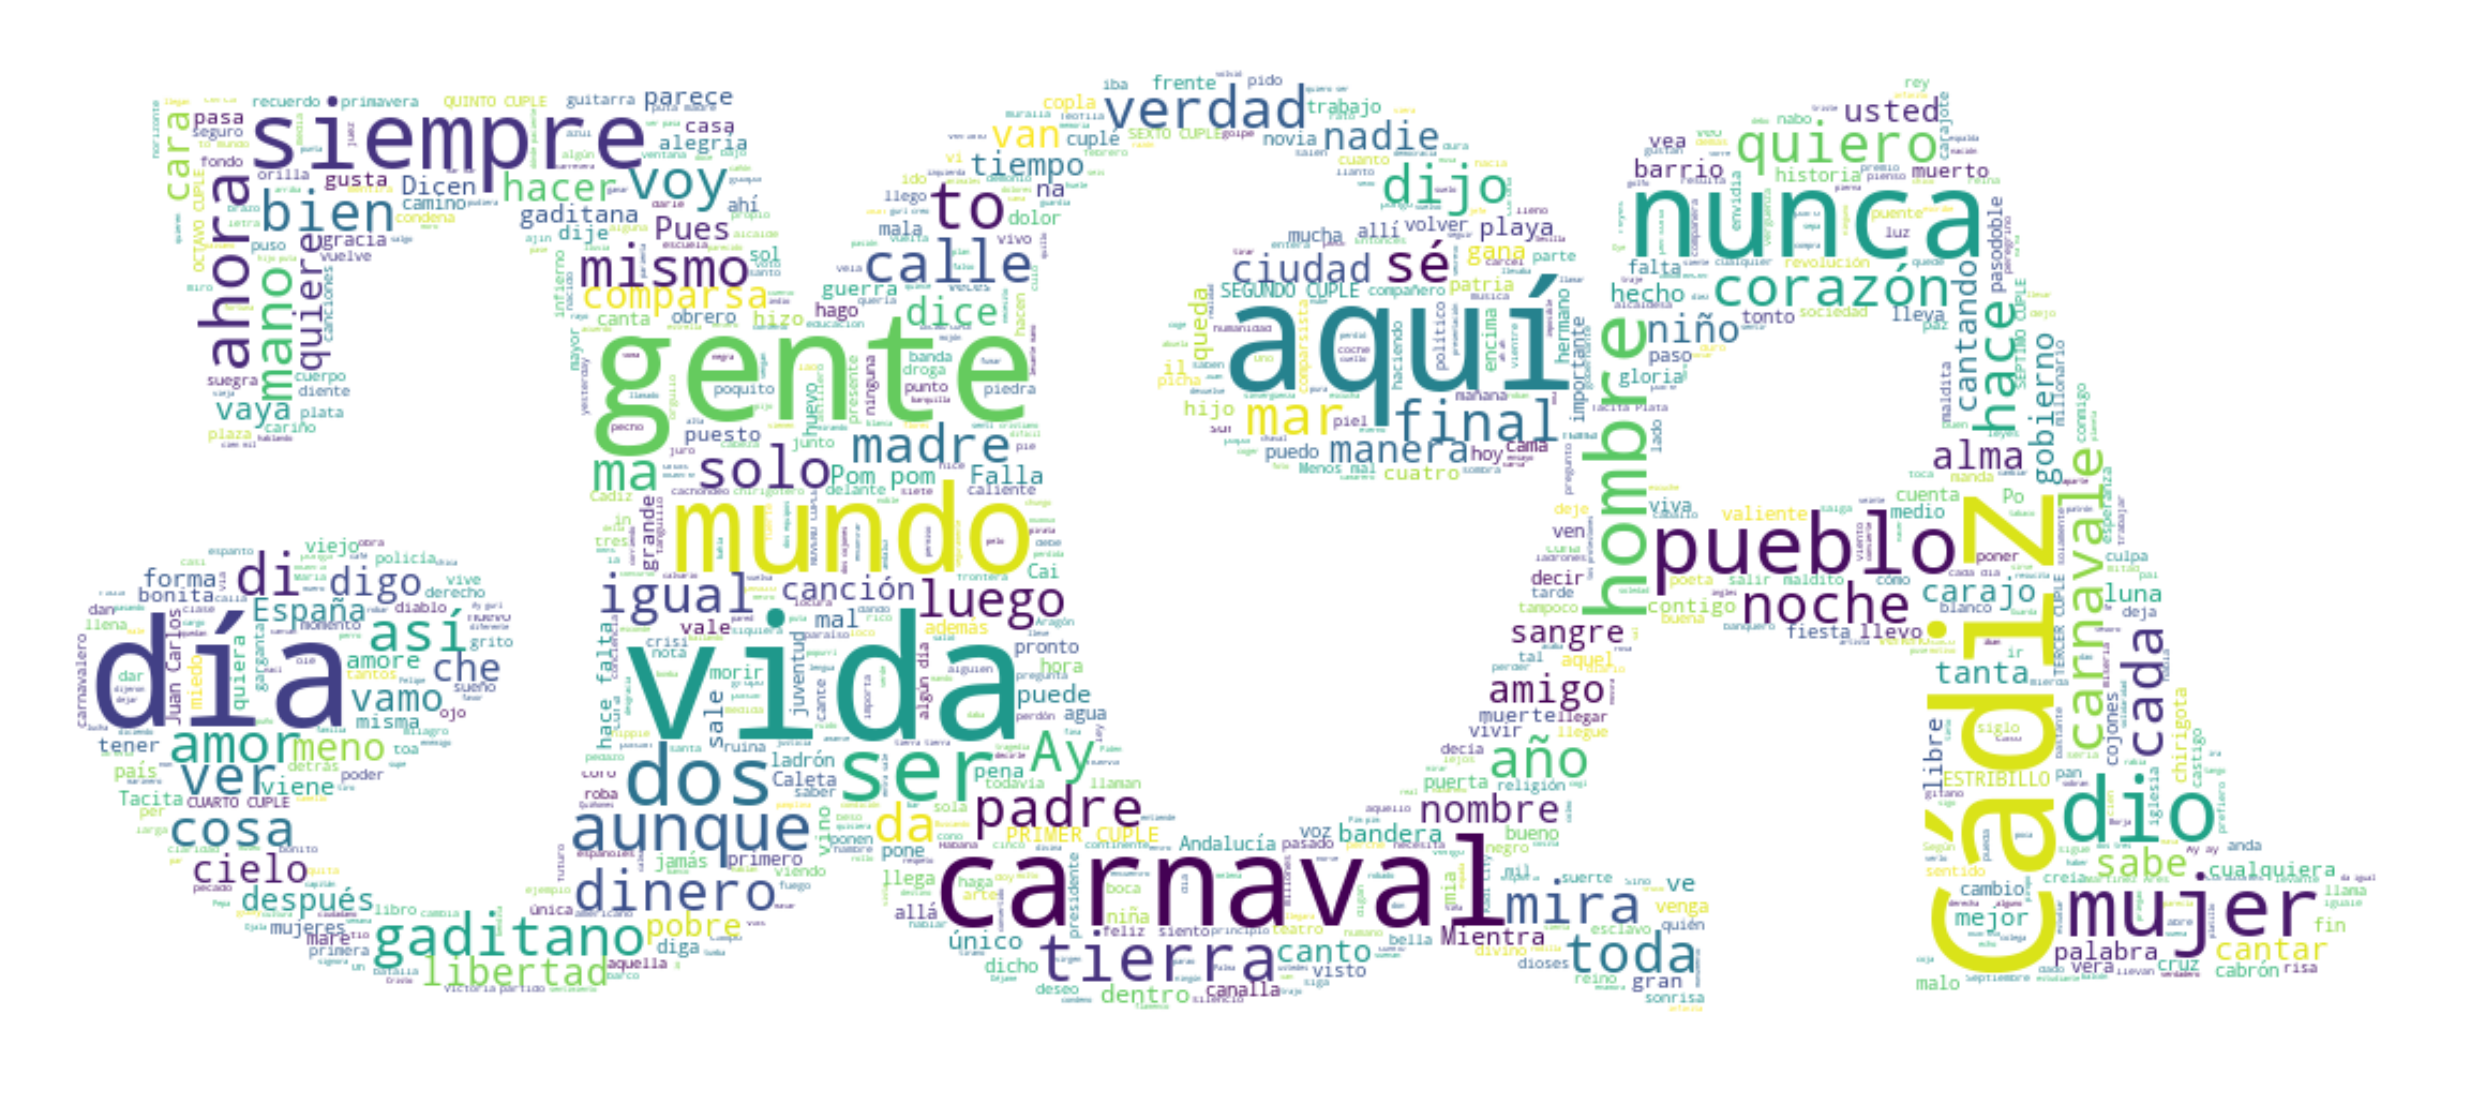

In [7]:
# Instanciamos un objeto tipo WordCloud
jca_wc = WordCloud(background_color='white', max_words=2000, mask=jca_mask, stopwords=stop_words)

# Generamos la nube
jca_wc.generate(text_to_analyze)

# Dibujamos la nube
fig = plt.figure()
fig.set_figwidth(44) # Modificar en función del tamaño en el que se quiera la visualización
fig.set_figheight(72) # Ídem

plt.imshow(jca_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Conclusiones<a id="5"></a>

Como podemos observar en la visualización anterior, las palabras que más empleó el autor como letrista de agrupaciones carnavalescas, son:
* **CÁDIZ**
* **VIDA**
* **GENTE**
* **AQUÍ** (¿tendrá algo que ver con "algo que hay que hacer" en Cádiz? - pequeña licencia humorística :) -)
* **DÍA**

Además, podemos apreciar otras palabras con una frecuencia de aparición algo menor pero que, a título personal, me "saben" mucho a JCA.

A los aficionados del Carnaval de Cádiz, ¿qué os parece que sean éstas las palabras más usadas por el trístemente desaparecido autor? ¿Os ha sorprendido? ¡Dejad vuestros comentarios!

NOTA: el código y la máscara puedes encontrarlos en este [repositorio](https://github.com/GuilleHM/Tribute_to_El_Capitan_Veneno) en GitHub.


<h1 align=center><font size = 7>DEP, Maestro.</font></h1>

